# Demystifying ARMA Models

Last week, I finished a project where I identified the five zip codes in the city of Baltimore, Maryland where an individual would expect the highest return on investment for buying a house, living in the house, then reselling after two years. You can check out my github repository for the project [here](https://github.com/sethchart/Baltimore-Real-Estate-Investment). In that project, I used Seasonal AutoRegressive Integrated Moving Average (SARIMA) models to forecast house prices based on historical data that I collected from Zillow.

In this post I want to take a closer look at these powerful time series models and try to get some intuition for how they work. A SARIMA model is a fairly complex type of time series model that combines several ideas to provide a flexible framework for modeling time series data. I want to  focus on a few of the core ideas that make up the the simpler ARMA models that are the inspiration for SARIMA models.

## What is a time series?

First thing's first, what kind of data are we trying to model? Time series data. What does that mean? How about a few examples.

### Example 1 

Suppose that you are using a workout app and every morning you weigh yourself and record your weight in the app. The list of all of your weights is a time series. The list of weights represents the history of your weight over a period of time, measured at regular time intervals. 

### Example 2 

Suppose that you record the total amount of money that you spend at the end of each month. The list of expenditures is a time series. The list represents the history of your spending over a period of time, measured at regular time intervals. 

### Definition 

Given one measurable quantity, a time series is a list of measurements of that quantity taken at regular time intervals.

## Recurrence Relations

A time series is fundamentally a list of numbers. The list below are weights from my own fitness tracker app collected every morning starting on 2020-11-16 and ending on 2020-11-22. 

In [1]:
weights = [172.6, 172.6, 172.1, 171.7, 172.6, 171.0, 172.8]

Mathematicians like to use compact notation for lists like the one above. A mathematician might call the list above $w$. Then, they would refer to the very first number in the list by the name $w_0$, so $w_0 = 172.6$. This is pretty similar to the way we work with this list in python. If we want the first number in the list, we type `weights[0]` which returns 172.6. The function below lists out all of the numbers in the weights list with both mathematical notation and python syntax.

In [2]:
from IPython.display import display, Markdown
def print_weights():
    for k in range(len(weights)):
        display(Markdown(f"$w_{k}$ = weights[{k}] = {weights[k]}"))
        
print_weights()

$w_0$ = weights[0] = 172.6

$w_1$ = weights[1] = 172.6

$w_2$ = weights[2] = 172.1

$w_3$ = weights[3] = 171.7

$w_4$ = weights[4] = 172.6

$w_5$ = weights[5] = 171.0

$w_6$ = weights[6] = 172.8

One common way to describe a list of numbers is by providing an equation that allows you to compute a new value of the list using previous values of the list. Usually we need to provide the equation and a few values to get the ball rolling. Let's look at a couple of classic examples.

### Example 3
The equation below says that for any whole number $n$ that is greater than or equal to one, the $n$th value in my list is just two times the previous ($(n-1)$st) value in the list.

$$a_n = 2a_{n-1} \text{ for } n \ge 1, a_0 = 1.$$

We are also given a value ($a_0 = 1$) to get the ball rolling. We can compute the first couple of values by hand:

$n = 1$ is greater than or equal to one, so our equation tells us that:

$$a_1 = 2a_0$$

But we were given $a_0 = 1$, so we see that:

$$a_1 = 2(1) = 2$$

Now that we know $a_1$ let's compute $a_2$.

$$a_2 = 2 a_1$$

But we know that $a_1 = 2$, so we get can compute.

$$a_2 = 2(2) = 4$$

But, why do math by hand in a python notebook. Let's check out the first ten values in this list $a$.

In [3]:
import numpy as np
def compute_sequence(coefficients, initial_conditions, n_values):
    order = len(coefficients)
    sequence = initial_conditions
    while len(sequence) <= n_values:
        tail = sequence[-order:][::-1]
        new_value = np.dot(tail, coefficients)
        sequence.append(new_value)
    return sequence

compute_sequence(coefficients=[2], initial_conditions=[1], n_values=10)

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

As you can see the equation above describes the powers of two.

### Example 4
See if you can compute the first ten values in the list described by the equation below. 

$$ f_n = f_{n-1} + f_{n-2} \text{ for } n\ge 2, f_0 = 1\; \text{ and } f_1 = 1.$$

Now, check your answer by running the cell below.

In [4]:
compute_sequence(coefficients=[1, 1], initial_conditions=[1, 1], n_values=10)

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89]

This is a pretty famous example, find out more [here](https://en.wikipedia.org/wiki/Fibonacci_number).

The equations that we used in the examples above are called **Homogeneous Linear Recurrence Relations**. 

### Definition
A **Homogeneous Linear Recurrence Relation** of *order* $k$ with *coefficients* $c_1, c_2, ..., c_{k}$ and *initial conditions* $i_0, i_1, ..., i_{k-1}$ is an equation of the form

$$ a_n = c_1 a_{n-1} + c_2 a_{n-2} + ... + c_{k} a_{n-k} \text{ for } n \ge k, a_0 = i_0, a_1 = i_1, ..., a_{k-1} = i_{k-1}.$$

#### Notes

The equation describes a list of values also commonly called as *sequence*.

### Example 5

Below we plot the first ten values of the Linear Recurrence Relation of order 2 with coefficients $c_1 = 1, c_2 = -\tfrac{1}{2}$, and and initial conditions $a_0 = -3$ and $a_1 = 1$. This can be written as the equation below.

$$ a_n = (1)a_{n-1} + \left(-\tfrac{1}{2}\right)a_{n-2} \text{ for } n \ge 2, a_0 = -3, a_1 = 1. $$

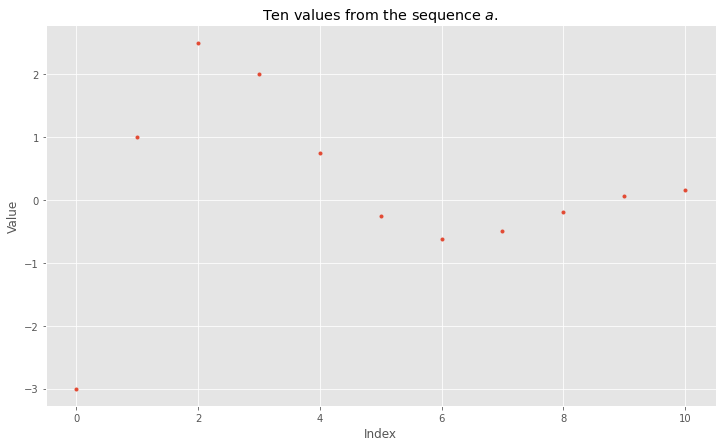

In [5]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
seq = compute_sequence(coefficients=[1, -1/2], initial_conditions=[-3, 1], n_values=10)
plt.figure(figsize=(12,7));
plt.plot(seq, '.');
plt.title("Ten values from the sequence $a$.");
plt.xlabel("Index");
plt.ylabel("Value");

## Autoregressive models

Recurrence relations are a fantastic way to describe a list of numbers, but you might notice that they are pretty rigid. Once you know a few values to get the ball rolling, you can find as many values of your list as you want by doing some simple arithmetic. 

If we are thinking about a time series, like my weight in my fitness app, I definitely don't expect to find a formula that would let me take the first couple of weights and compute my exact weight, ten, twenty, or three hundred and sixty five days in the future. I would expect to be able to identify some general trend and forecast my weight a few days into the future. But, I would also expect to see quite a bit of variation day-to-day. There are all sorts of external factors that affect my weight day-to-day that I cannot infer from a list of weights that I have measured in the past. How much I have been moving, how much I have been eating, how much water I have been drinking, how much I have been sleeping, these are all factors that affect my daily weight measurements. I am no expert, but there are myriad other complex biological processes and variations that also have small day-to-day effects on my weight.

The point here is that while a recurrence relation is a useful way to describe a list of numbers, when we think about time series data, we would expect that there are external factors that influence the values in the time series that cannot be known by just knowing the past values of the time series. 

Mathematicians have a standard trick for analyzing problems where parts of the problem are unknown or unknowable. Throw in some randomness! That is what we are going to do here. We will take our recurrence relation idea and add a little randomness. 

### Example 6

Let's take the recurrence relation from Example 5 and modify it by adding a random number $r_n$ each time we compute a new value. 

$$ a_n = (1)a_{n-1} + \left(-\tfrac{1}{2}\right)a_{n-2} + r_n \text{ for } n \ge 2, a_0 = -3, a_1 = 1. $$

The idea is that when I compute a new value in my list, I do the same arithmetic that I did before, but then I add a random number that represents the effects of all of the unknown or unknowable external factors that influence the time series that I want to model. 

Let's assume that all of the random numbers are drawn from a normal distribution with mean zero and standard deviation 0.2.

In [6]:
def compute_ar_sequence(coefficients, initial_conditions, sigma, n_values):
    order = len(coefficients)
    sequence = initial_conditions
    while len(sequence) <= n_values:
        r = np.random.randn()*sigma
        tail = sequence[-order:][::-1]
        new_value = np.dot(tail, coefficients) + r
        sequence.append(new_value)
    return sequence

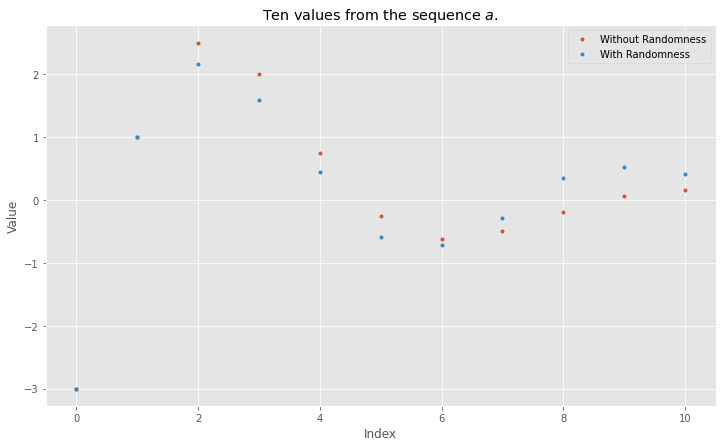

In [7]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
ar_seq = compute_ar_sequence(coefficients=[1, -1/2], initial_conditions=[-3, 1], sigma=0.2, n_values=10)
plt.figure(figsize=(12,7));
plt.plot(seq, '.');
plt.plot(ar_seq, '.');
plt.title("Ten values from the sequence $a$.");
plt.xlabel("Index");
plt.ylabel("Value");
plt.legend(['Without Randomness', 'With Randomness']);

We can see that the behavior of the sequence with added randomness is similar to the original sequence, but it now has a mechanism that incorporates the unknown external factors. 

The equation that we used in Example 6 is called an **Auto Regressive Model**. 

### Definition
An **Autoregressive Model** of *order* $k$ with *coefficients* $c_1, c_2, ..., c_{k}$ and *initial conditions* $i_0, i_1, ..., i_{k-1}$ is an equation of the form

$$ a_n = c_1 a_{n-1} + c_2 a_{n-2} + ... + c_{k} a_{n-k} + r_n \text{ for } n \ge k, a_0 = i_0, a_1 = i_1, ..., a_{k-1} = i_{k-1}.$$

The numbers $r_n$ are random numbers drawn independently at random from the same distribution with mean zero and finite standard deviation.
#### Notes

When a list of numbers is completely or partially constructed from random numbers, it is commonly called a *stochastic process*.

My description of the random numbers $r_n$ is slightly more restrictive than some definitions, so what I have described is always an autoregressive model, but there are some autoregressive models that won't satisfy my definition. 

## Moving Average Models

Autoregressive models provide more flexibility for describing a time series. If I want to model my weight data, I could try to find a recurrence relation that describes how my current weight depends on previous weights. I know that there are factors that affect my weight that I cannot infer from my previous weights. To incorporate these factors into my model, I can upgrade to an autoregressive model where I add a small random number at each step. The distribution of these random numbers represents how I believe that external factors influence my weight. Most importantly, the standard deviation of these random numbers is a good representation of how much I think my weight fluctuates due to these external factors. From experience I would guess that a standard deviation of one or two pounds might be reasonable for me. 

It seems like we should be done at this point, but there is one more way that we can make our model more flexible. Notice that when I compute my prediction for my weight today, I add my random number, then tomorrow I add a new random number that has nothing to do with my random number from today. 

### Example 7

To see why this might not be flexible enough, let's imagine that in our autoregressive model of my weight, the only external factor is how much I exercise. You clearly cannot infer how much I have exercised today from my weights from the last few days, so we will model the influence of exercise as a random number representing how much I have exercised today. But exercise has a long term effect on my weight. If I work out extra hard today, then that might cause a slight reduction in weight today, a slightly larger reduction in weight tomorrow and finally a small reduction in weight two days after the exercise. The effects of exercise are spread out over a few days. This cannot be modeled using the autoregressive model, because todays random number representing my exercise has no influence over the random number tomorrow. 

This is not particularly hard to solve. I want to model the effect of my exercise as spread out over three days, so I can just split it up and add it to the appropriate days as I compute new values. To be more precise, let's say that $r_1 = -0.08$ pounds is the overall reduction in weight caused by my bout of exercise on day one. Let's say that, generally, whatever the effect of exercise is on my weight, 10% manifests of the day of the exercise, 60% manifests the day after and 30% manifests on the second day after exercise. So, I should add $0.1 r_1$ when I compute $w_1$, $0.6 r_1$ when I compute $w_2$, $0.3 r_1$ when I compute $w_3$. I have incorporated the full influence of my day one exercise into my list of weights, so when I compute $w_4$, I don't need to add any $r_1$

Now, this is where things get a bit tricky for a second, on days two, three, and four, I get new numbers that represent the total effect of exercise on those days as well. I need to add all of these bits together to find out how all of my exercise influences my weight. For the sake of keeping things simple let's assume that there is no $r_0$ representing exercise on day zero.

The total effect of exercise on day one ($e_1$) is 10% of my overall day one exercise.

$$e_1 = 0.1 r_1$$

The total effect of exercise on day two ($e_2$) is 60% of my day one exercise plus 10% of my day two exercise.

$$e_2 = 0.1 r_2 + 0.6 r_1$$

The total effect of exercise on day three ($e_3$) is 10% of my day three exercise, plus 60% of my day two exercise, plus 30% of my day one exercise.

$$ e_3 = 0.1 r_3 + 0.6 r_2 + 0.3 r_1$$

The total effect of exercise on day four ($e_4$) is 10% of my day four exercise, plus 60% of my day three exercise, plus 30% of my day two exercise. Day one exercise has no effect on day four weight

$$ e_4 = 0.1 r_4 + 0.6 r_3 + 0.3 r_2$$

With this simple modification, we have allowed our external factors to influence the present and some finite number of steps into the future. 

What we described in Example 7 was the **Moving Average** portion of an **Auto Regressive Moving Average Model**. 

### Definition
An **Autoregressive Moving Average Model** with *autoregressive order* $p$ and *moving average order* $q$ with *autoregressive coefficients* $c_1, c_2, ..., c_{p}$, *initial conditions* $i_0, i_1, ..., i_{k-1}$, and *moving average coefficients* $d_0, d_1, ..., d_{q-1}$, is an equation of the form

$$ a_n = \left(c_1 a_{n-1} + c_2 a_{n-2} + ... + c_{p} a_{n-p}\right) + \left(d_0 r_n + d_1 r_{n-1} + ... + d_{q-1} r_{n-q+1}\right) \text{ for } n \ge k, a_0 = i_0, a_1 = i_1, ..., a_{k-1} = i_{k-1}.$$

The numbers $r_n$ are random numbers drawn independently at random from the same distribution with mean zero and finite standard deviation.
#### Notes

In the equation above, the first set of parentheses surround the linear recurrence relation, the second set of parentheses surround the moving average term. By using the more complicated moving average random term we upgrade from an autoregressive model to an autoregressive moving average model. 

### Example 8

To wrap things up, let's see what happens if we make the autoregressive model from Example 6 into an autoregressive moving average model with moving average coefficients $d_0 = 0.1$, $d_1 = 0.6$, and $d_2 = 0.3$ as we did in Example 7.

In [14]:
def compute_arma_sequence(rr_coefficients, ma_coeffecents, initial_conditions, sigma, n_values):
    p = len(rr_coefficients)
    q = len(ma_coeffecents)
    values = initial_conditions
    shocks = [0]*q
    while len(values) <= n_values:
        r = np.random.randn()*sigma
        shocks.append(r)
        value_tail = values[-p:][::-1]
        shock_tail = shocks[-q:][::-1]
        new_value = np.dot(value_tail, rr_coefficients) + np.dot(shock_tail, ma_coeffecents)
        values.append(new_value)
    return values

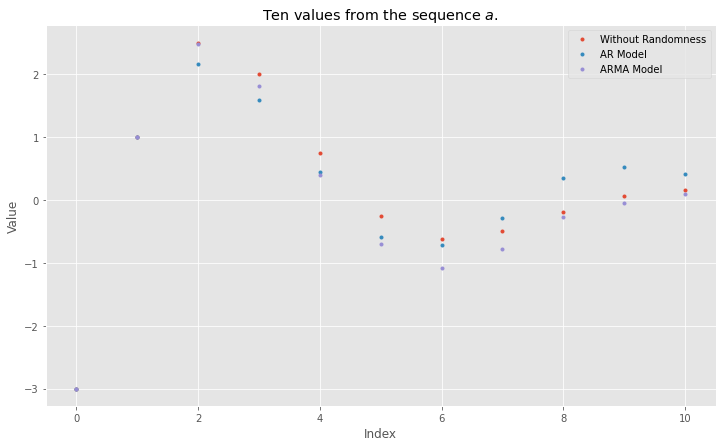

In [15]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
arma_seq = compute_arma_sequence(rr_coefficients=[1, -1/2], 
                                 ma_coeffecents=[0.1, 0.6, 0.3], 
                                 initial_conditions=[-3, 1], 
                                 sigma=0.2, 
                                 n_values=10)
plt.figure(figsize=(12,7));
plt.plot(seq, '.');
plt.plot(ar_seq, '.');
plt.plot(arma_seq, '.');
plt.title("Ten values from the sequence $a$.");
plt.xlabel("Index");
plt.ylabel("Value");
plt.legend(['Without Randomness', 'AR Model', 'ARMA Model']);

# Conclusion

In this post we saw that:

* Time series data is a list of values that come from repeated measurements of exactly one quantity at regular time intervals.
* Linear Recurrence Relations provide a powerful framework for describing the present value on a list in terms of its previous values.
* Autoregressive models account for unknown or unknowable external factors by modeling their influence as a random number, which is added to a Linear Recurrence Relation.
* AutoRegressive Moving Average (ARMA) models extend autoregressive models by allowing the influence of external factors to affect not only the present, but also finitely many steps into the future.

# Future Work

In the future, I would like to explore time series modeling in more depth by addressing some topics that did not make it into this post. 
* Stationarity of time series data and stochastic processes.
* The Autocorrelation Function and the Partial Autocorrelation Function
* Solutions to Homogeneous Linear Recurrence Relations and roots of the Characteristic Polynomial.
* Differencing time series data and Random Walk processes. 
* Multiplicative models and when to use them.